# Start Time

In [73]:
import time

start_time = time.time()

# Online Retail

## ASK

### Reading About the Domain

#### Why should we segment customers?  
As per the Pareto Principle, 80% of outcomes result from 20% of all the causes of any given event.  
  
In business terms, we can say that 20% of customers contribute 80% share of the total revenue of a company. That’s why finding this set of people is important. By understanding these key customers, companies can create special offers and strategies that lead to higher profits.

#### What are the factors used to segment customers?
- Demographic
- Recency, Frequency, and Monetary
- Behavioral
- Psychographic 
- Geographical

### Project Goals

- Clean the Data
- Segment the Customers based on their behaviors
- Translate the meaning of the clusters to business wise insights

## PREPARE

### Importing needed packages

In [74]:
# Needed packages to manipulate the data
import pandas as pd
import numpy as np

# Needed packages to visualize the data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Needed packages to prepare the data for ML
from sklearn.preprocessing import MinMaxScaler

# Needed packages to apply the ML models
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

### Uploading the Dataset

In [75]:
path = "C:/Users/muazs/Desktop/Online Retail.xlsx"

data = pd.read_excel(path) 

data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## PROCESS

### Exploring the Dataset in Excel Summary

After using filters to view the data values from the drop down list, I have noticed weird numbers in the quantity and unit price.

In the part about quantities, I wanted to figure out if the cases were due to returns or just mistakes. So, I looked into whether the customers had bought the same product before and if the positive quantities were greater than or equal to the returned quantities. It turned out to be true. I also noticed that some return invoices start with the letter "C." This led me to think that invoices without the "C" and have negative quantities might be incorrect, especially because they didn't have a customer ID, making it hard for me to check if they had recently purchased the product.

In the unit price section, I noticed only two negative values. These were tied to products labeled as 'Adjust bad debt,' indicating they were trying to correct financial issues by subtracting amounts. Also, I found some unit prices listed as 0, which doesn't seem logical and should be removed.

#### Creating a copy from the Dataset

In [76]:
datae = data.copy(deep=True)

#### Handling Quantity Errors

In [77]:
# Converting InvoiceNo to string due to an error in the below code
datae['InvoiceNo'] = datae['InvoiceNo'].astype(str)

# Removing negative values from Quantity where InvoiceNo doesn't contain C
datae = datae[~((datae['InvoiceNo'].str.contains('C')) & (datae['Quantity'] < 0))]

In [78]:
datae[datae['Quantity'] == -9600]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
225529,556690,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.0,NaN,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.0,NaN,United Kingdom


#### Handling Unit Price Errors

In [79]:
datae.shape

(532621, 8)

In [80]:
# Removing values less than or equal to 0 in UnitPice
datae = datae[datae['UnitPrice'] > 0]

In [81]:
datae.shape

(530104, 8)

### Exploring the Dataset

#### Creating a Copy from the datae for Processing

In [82]:
datap = datae.copy(deep=True)

#### Shape

In [83]:
datap.shape

(530104, 8)

The data have 530K rows and 8 columns after the excel exploring cleanings

#### Description

In [84]:
datap.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,530104.0,10.542037,155.524124,1.000,1.00,3.00,10.00,80995.00
UnitPrice,530104.0,3.907625,35.915681,0.001,1.25,2.08,4.13,13541.33
CustomerID,397884.0,15294.423453,1713.141560,12346.000,13969.00,15159.00,16795.00,18287.00


In [85]:
datap.describe(include=['O']).T

,count,unique,top,freq
InvoiceNo,530104,19960,573585,1114
StockCode,530104,3922,85123A,2265
Description,530104,4026,WHITE HANGING HEART T-LIGHT HOLDER,2323
Country,530104,38,United Kingdom,485123


We can see some of the things to investiate further more into like:
- Customer ID needs to be string and there are some nulls 
- The United Kingdom is repeated 495K out of 541K

#### Column Types

In [86]:
datap.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

We need to change the CustomerID type to object

#### Timeline of the Data

In [87]:
min_date = datap['InvoiceDate'].min()
max_date = datap['InvoiceDate'].max()

print(min_date)
print(max_date)
print((max_date - min_date).days)

2010-12-01 08:26:00
2011-12-09 12:50:00
373


The data's timeline starts from 1/12/2010 to 9/12/2011 which is approximately one year long (373 days)

### Removing Irrelevant Attributes

#### Checking Country

In [88]:
datap['Country'].nunique()

38

In [89]:
datap['Country'].value_counts(normalize=True)*100

United Kingdom          91.514684
Germany                  1.705326
France                   1.585915
EIRE                     1.488387
Spain                    0.468587
Netherlands              0.445007
Belgium                  0.383132
Switzerland              0.370871
Portugal                 0.283152
Australia                0.222975
Norway                   0.202036
Italy                    0.142991
Channel Islands          0.141104
Finland                  0.129220
Cyprus                   0.115826
Sweden                   0.085078
Unspecified              0.084134
Austria                  0.075080
Denmark                  0.071684
Poland                   0.062252
Japan                    0.060554
Israel                   0.055649
Hong Kong                0.053574
Singapore                0.041879
Iceland                  0.034333
USA                      0.033767
Canada                   0.028485
Greece                   0.027353
Malta                    0.021128
United Arab Em

Since 91.4% of the data is in United Kingdom out of 38 and the others are not equally distributed. We will remove it so that would not lead to unfairness to the other countries in the model.

In [90]:
datap.drop('Country', axis=1, inplace=True)

### Removing Duplicates

In [91]:
datap.duplicated().sum()

5226

In [92]:
dataDup = datap[datap.duplicated()]
dataDup.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0
587,536412,22273,FELTCRAFT DOLL MOLLY,1,2010-12-01 11:49:00,2.95,17920.0
589,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,2010-12-01 11:49:00,3.75,17920.0
594,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1,2010-12-01 11:49:00,2.10,17920.0
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0
600,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2,2010-12-01 11:49:00,3.75,17920.0


After looking into the duplicated transactions, it makes sense. Imagine being at a grocery store, sometimes we accidentally pick up the same item more than once and put them in different spots in the cart. So, when the cashier scans these items and adds them to the bill, they seem like duplicates. But really, it's just because of how we placed them in the cart, not because of any mistake. So, none of the duplicates will be removed.

### Handling Outliers / Logical Errors

#### Fixing Quantity

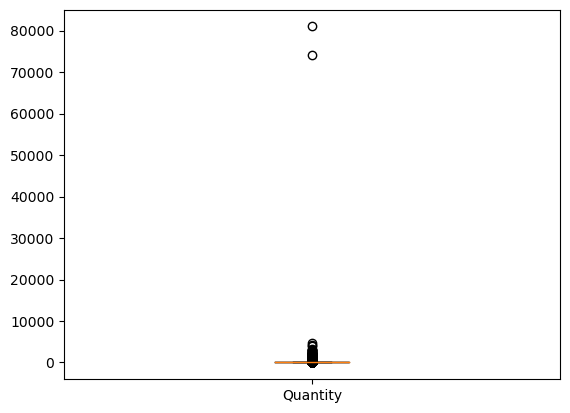

In [93]:
# Drawing a boxplot to check if outliers exist
cols = ['Quantity']

plt.boxplot(datap[cols].values, labels=cols)
plt.show()

In [94]:
# Removing the otliers using the Interquartile Range Outlier Detection
q25 = np.percentile(datap['Quantity'], 25)
q75 = np.percentile(datap['Quantity'], 75)
iqr = q75 - q25

lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

datap = datap.loc[(datap['Quantity'] >= lower_bound) & (datap['Quantity'] <= upper_bound)]

In [95]:
# To know the range of the cleaned column
print(datap['Quantity'].max())
print(datap['Quantity'].min())

23
1


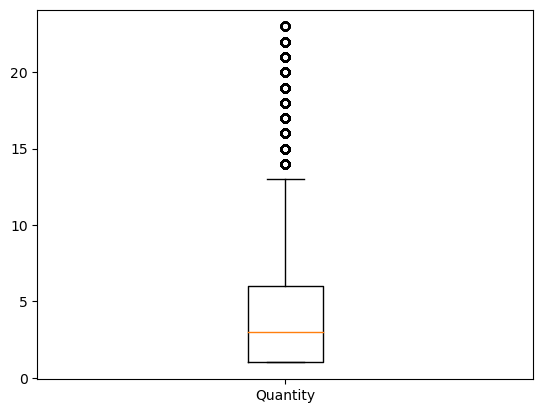

In [96]:
# Drawing a boxplot to check if outliers are removed
cols = ['Quantity']

plt.boxplot(datap[cols].values, labels=cols)
plt.show()

#### Fixing Unit Price

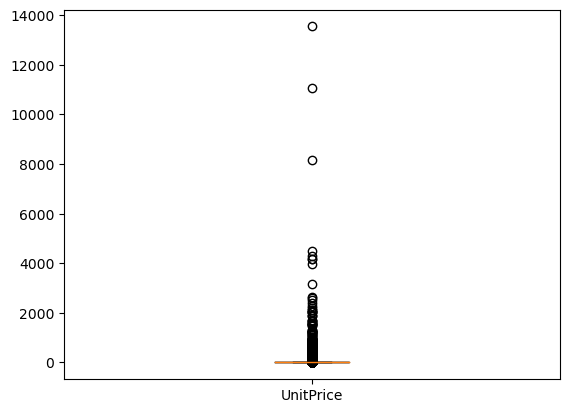

In [97]:
# Drawing a boxplot to check if outliers exist
cols = ['UnitPrice']

plt.boxplot(datap[cols].values, labels=cols)
plt.show()

In [98]:
# Removing the otliers using the Interquartile Range Outlier Detection
q25 = np.percentile(datap['UnitPrice'], 25)
q75 = np.percentile(datap['UnitPrice'], 75)
iqr = q75 - q25

lower_bound = q25 - 1.5 * iqr
upper_bound = q75 + 1.5 * iqr

datap = datap.loc[(datap['UnitPrice'] >= lower_bound) & (datap['UnitPrice'] <= upper_bound)]

In [99]:
# To know the range of the cleaned column
print(datap['UnitPrice'].max())
print(datap['UnitPrice'].min())

8.5
0.001


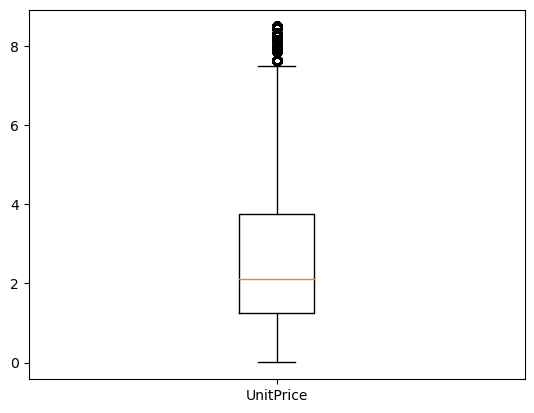

In [100]:
# Drawing a boxplot to check if outliers are removed
cols = ['UnitPrice']

plt.boxplot(datap[cols].values, labels=cols)
plt.show()

### Handling Nulls

In [101]:
datap.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     116226
dtype: int64

After fixing the main issues, the description column doesn't have any missing values. This means our previous steps worked well.  

#### Fixing CustomerID

In [102]:
# Removing the nulls in the CustomerID column
datap.dropna(subset=['CustomerID'], inplace=True)

In [103]:
# Checking if nulls are removed
datap['CustomerID'].isnull().sum()

0

### Changing Columns Types

#### Changing CustomerID Type

In [104]:
datap['CustomerID'] = datap['CustomerID'].astype(str)
print(datap.dtypes['CustomerID'])

object


## ANALYZE

### Creating a Copy from the Cleaned Dataset

In [105]:
dataa = datap.copy(deep=True)

### Enrichment

Recency, frequency, monetary value (RFM) is a model used in marketing analysis that segments a company’s consumer base by their purchasing patterns or habits. In particular, it evaluates customers’ recency (how long ago they made a purchase), frequency (how often they make purchases), and monetary value (how much money they spend).

RFM is then used to identify a company’s or an organization’s best customers by measuring and analyzing spending habits to improve low-scoring customers and maintain high-scoring ones.

Since we can extract those information from our dataset, we will be using the RFM to analyze our data.

#### Creating Recency Column

In [106]:
# Calculating the max date and adding one day so we would avoid getting 0 in recency
# I also used that date not today's date because I will get large numbers since the data ended in 2011 and we are in 2023
max_date = max(dataa['InvoiceDate']) 
next_day = max_date + pd.Timedelta(days=1) 

# Building the Recency column
dataa['Recency'] = (next_day - dataa['InvoiceDate']).dt.days

#### Creating Frequency Column

In [107]:
# Building the Frequency column by getting the unique count of the InvoiceNo for each CustomerID
dataa['Frequency'] = dataa.groupby(['CustomerID'])['InvoiceNo'].transform(lambda x: x.nunique())

#### Creating Monetary Column

In [108]:
# Building the Monetary column by multiplying the UnitPrice and Quantity to get the total sales
dataa['Monetary'] = dataa['UnitPrice'] * dataa['Quantity']

### Creating RFM Table for the Classification Models

In [109]:
# Creating a new table listing unique customers only and their total RFM values
rfm = dataa.groupby('CustomerID').agg({
    'Recency': 'min',            # Smallest recency (most recent date)
    'Frequency': 'first',        # First value of Frequency (since it's the same for each customer)
    'Monetary': 'sum'            # Total monetary value (total sales)
}).reset_index()

In [110]:
rfm.head(10)

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,2866.77
1,12348.0,249,1,17.00
2,12349.0,19,1,1155.75
3,12350.0,310,1,274.00
4,12352.0,36,7,1232.44
5,12353.0,204,1,29.30
6,12354.0,232,1,668.55
7,12355.0,214,1,189.00
8,12356.0,246,2,648.44
9,12357.0,33,1,2424.61


In [111]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4170.0,93.108153,100.112520,1.0,18.0000,51.000,146.000,374.00
Frequency,4170.0,3.978897,6.942386,1.0,1.0000,2.000,4.000,193.00
Monetary,4170.0,956.630476,2023.763537,1.9,196.0825,438.105,1059.855,78186.73


At the end, I gained 417 unique customers and those are the ones whom I will classify

### ML Models

#### Creating a Copy from rfm for the ML Models

In [112]:
rfm_ml = rfm.copy(deep=True)

In [113]:
rfm_ml.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,2866.77
1,12348.0,249,1,17.00
2,12349.0,19,1,1155.75
3,12350.0,310,1,274.00
4,12352.0,36,7,1232.44


#### Extracting the Features

In [114]:
rfm_ml = rfm_ml.iloc[:,1:]

#### Normalizing the Data

In [115]:
original_columns = rfm_ml.columns  # Store the column names

scaler = MinMaxScaler()
rfm_ml = scaler.fit_transform(rfm_ml)

# Convert the scaled NumPy array back to a pandas DataFrame
rfm_ml = pd.DataFrame(rfm_ml, columns=original_columns)

In [116]:
rfm_ml.head()

,Recency,Frequency,Monetary
0,0.002681,0.03125,0.036642
1,0.664879,0.00000,0.000193
2,0.048257,0.00000,0.014758
3,0.828418,0.00000,0.003480
4,0.093834,0.03125,0.015739


#### K-means

##### Elbow Graph

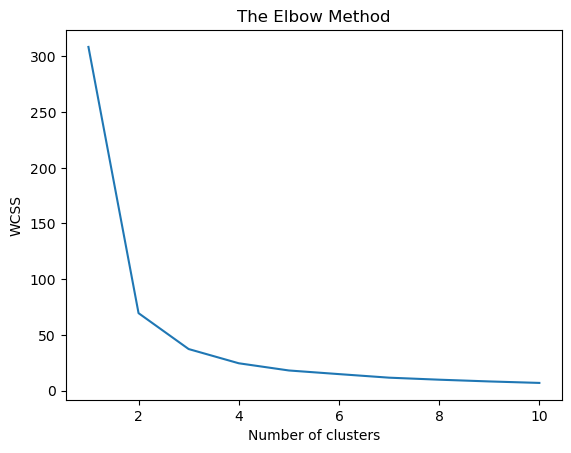

In [117]:
# Draw the elbow graph
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(rfm_ml)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The best numbers of clusters for K-means appears to be 3

##### Applying the Model

In [118]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(rfm_ml)

##### Plotting the Clusters and Centroids 

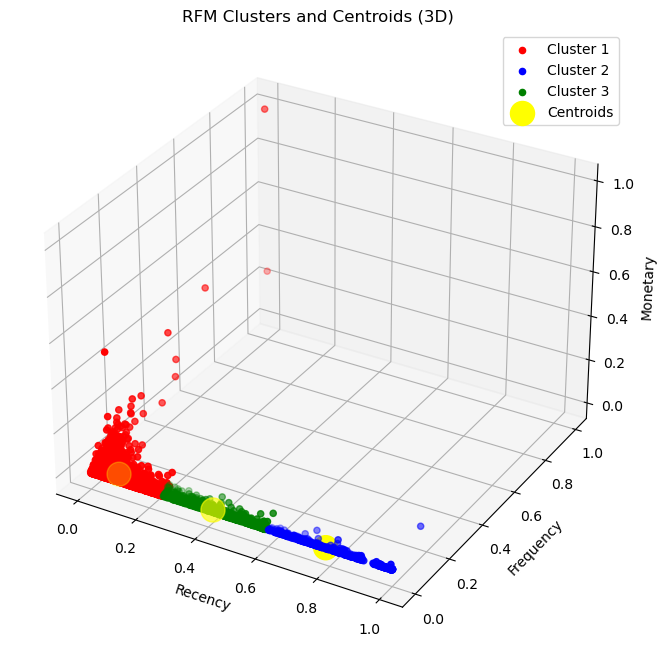

In [119]:
# ChatGPT

# Creating a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Visualizing the clusters
ax.scatter(rfm_ml[y_kmeans == 0]['Recency'], rfm_ml[y_kmeans == 0]['Frequency'], rfm_ml[y_kmeans == 0]['Monetary'], c='red', label='Cluster 1')
ax.scatter(rfm_ml[y_kmeans == 1]['Recency'], rfm_ml[y_kmeans == 1]['Frequency'], rfm_ml[y_kmeans == 1]['Monetary'], c='blue', label='Cluster 2')
ax.scatter(rfm_ml[y_kmeans == 2]['Recency'], rfm_ml[y_kmeans == 2]['Frequency'], rfm_ml[y_kmeans == 2]['Monetary'], c='green', label='Cluster 3')
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=300, c='yellow', label='Centroids')

# Setting labels for axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Adding a legend
ax.legend()

# Adding a title
plt.title('RFM Clusters and Centroids (3D)')

# Display the plot
plt.show()

##### Labeling Clusters Back to CustomerID

In [120]:
rfm['ClustersKM'] = y_kmeans+1 # I added one to avoid having 0 in the first cluster

In [121]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,ClustersKM
0,12347.0,2,7,2866.77,1
1,12348.0,249,1,17.00,2
2,12349.0,19,1,1155.75,1
3,12350.0,310,1,274.00,2
4,12352.0,36,7,1232.44,1


##### Analyzing the Clusters of the K-means

In [122]:
# Creating a new table listing the K-means clusters and their average RFM values and the count of customers
rfmAKM = rfm.groupby('ClustersKM').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'size'  
}).reset_index()

rfmAKM.rename(columns={'CustomerID': 'CustomerCount'}, inplace=True)

In [123]:
rfmAKM

,ClustersKM,Recency,Frequency,Monetary,CustomerCount
0,1,32.473873,5.065497,1250.125817,2794
1,2,294.077558,1.313531,259.664389,606
2,3,154.958442,2.133766,440.183027,770


Looking at the summary above, Cluster 1 stands out as my top customers. They've recently visited, order frequently, and spend the most.

Cluster 3 appears to be potentially lost customers. They haven't visited or ordered much, leading to moderate spending.

Meanwhile, Cluster 2 consists of lost customers. They haven't visited in a while, order infrequently, and spend the least.

#### Hierarichal Clustering

##### Dendrogram Graph

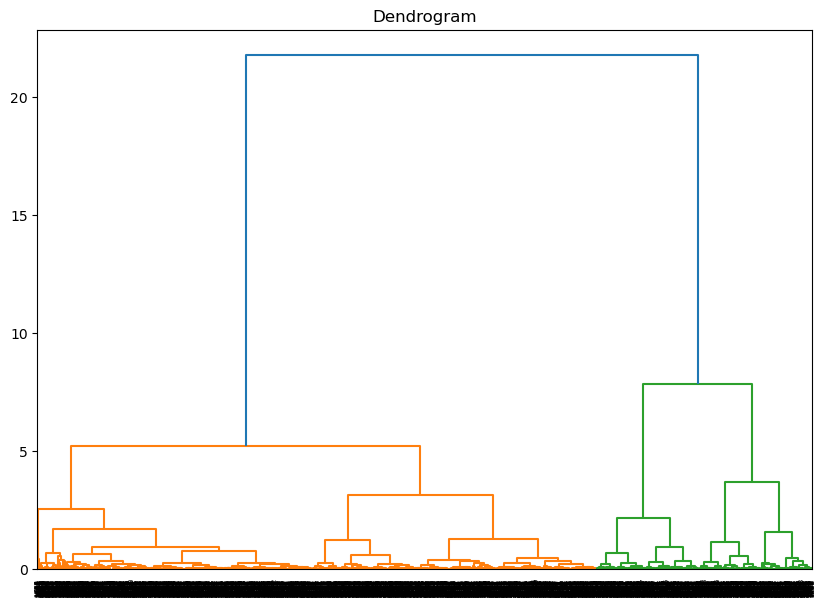

In [124]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(rfm_ml, method='ward'))

##### Applying the Model

In [125]:
hier = AgglomerativeClustering(n_clusters=2)
y_pred2 = hier.fit_predict(rfm_ml)

##### Plotting the Clusters

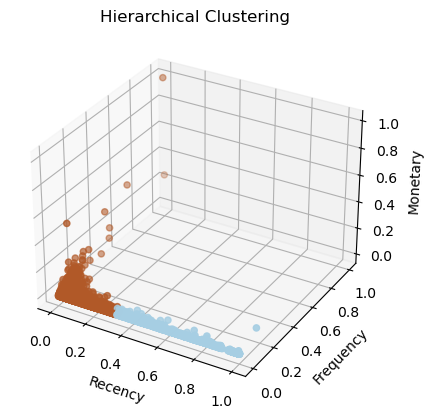

In [126]:
# ChatGPT

# Scatter plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_ml['Recency'], rfm_ml['Frequency'], rfm_ml['Monetary'], c=y_pred2, cmap='Paired')
ax.set_title("Hierarchical Clustering")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

plt.show()

##### Labeling Clusters Back to CustomerID

In [127]:
rfm['ClustersH'] = y_pred2+1 # I added one to avoid having 0 in the first cluster

In [128]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,ClustersKM,ClustersH
0,12347.0,2,7,2866.77,1,2
1,12348.0,249,1,17.00,2,1
2,12349.0,19,1,1155.75,1,2
3,12350.0,310,1,274.00,2,1
4,12352.0,36,7,1232.44,1,2


##### Analyzing the Clusters of the Hierarichal Clustering

In [129]:
# Creating a new table listing the Hierarichal Clustering clusters and their average RFM values and the count of customers
rfmAH = rfm.groupby('ClustersH').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'size'  
}).reset_index()

rfmAH.rename(columns={'CustomerID': 'CustomerCount'}, inplace=True)

In [130]:
rfmAH

,ClustersH,Recency,Frequency,Monetary,CustomerCount
0,1,235.720412,1.653516,330.337617,1166
1,2,37.753329,4.881491,1199.725507,3004


Looking at the summary, Cluster 2 is made up of valuable customers. They've been visiting, ordering often, and spend more.

Meanwhile, Cluster 1 includes less valuable customers. They haven't visited recently, order less frequently, and spend less.

## SHARE (for me)

In [131]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,ClustersKM,ClustersH
0,12347.0,2,7,2866.77,1,2
1,12348.0,249,1,17.00,2,1
2,12349.0,19,1,1155.75,1,2
3,12350.0,310,1,274.00,2,1
4,12352.0,36,7,1232.44,1,2


In [132]:
dataa.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Recency,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,374,34,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,374,34,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34


In [133]:
datas = dataa.merge(rfm[['CustomerID', 'ClustersKM', 'ClustersH']], on='CustomerID', how='left')
datas.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Recency,Frequency,Monetary,ClustersKM,ClustersH
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,374,34,15.30,2,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34,2,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,374,34,22.00,2,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34,2,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34,2,1


In [134]:
# Mapping for ClustersKM
clusters_km_mapping = {
    1: 'Top Customer',
    2: 'Lost Customer',
    3: 'Maybe Lost Customer'
}

# Apply mappings using .map()
datas['ClustersKM_Label'] = datas['ClustersKM'].map(clusters_km_mapping)

In [135]:
# Mapping for ClustersH
clusters_h_mapping = {
    1: 'Less Valuable Customer',
    2: 'High Valuable Customer'
}

# Apply mappings using .map()
datas['ClustersH_Label'] = datas['ClustersH'].map(clusters_h_mapping)

In [136]:
datas.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Recency,Frequency,Monetary,ClustersKM,ClustersH,ClustersKM_Label,ClustersH_Label
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,374,34,15.30,2,1,Lost Customer,Less Valuable Customer
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34,2,1,Lost Customer,Less Valuable Customer
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,374,34,22.00,2,1,Lost Customer,Less Valuable Customer
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34,2,1,Lost Customer,Less Valuable Customer
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,374,34,20.34,2,1,Lost Customer,Less Valuable Customer


In [137]:
#datas.to_excel('datas_for_PowerBI.xlsx', index=False)

# End Time

In [138]:
end_time = time.time()
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print("Total runtime:", minutes, "minutes and", seconds, "seconds")

Total runtime: 6 minutes and 5 seconds
